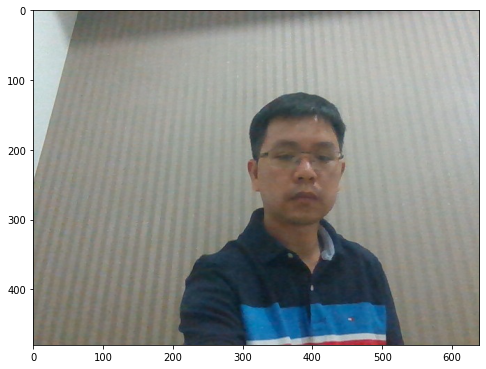

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

PATH = '/content/drive/MyDrive/AI Insight/hw 20 + 21/tracking_images4/'

height = 480
width  = 640
image_t1 = kimage.load_img(PATH+'img'+str(0)+'.jpg', target_size=(height, width))

plt.figure(figsize=(8,8))
plt.imshow(image_t1)

(480, 640, 3)
(160, 160, 3)


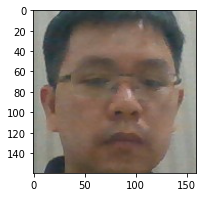

In [ ]:
# get template
x = 300
y = 140
patch_side = 160

image_t1_np = kimage.img_to_array(image_t1)
print(image_t1_np.shape)

template_t1 = image_t1_np[y:y+patch_side, x:x+patch_side, :]
print(template_t1.shape)

plt.figure(figsize=(3,3))
plt.imshow(template_t1/255.0)

In [ ]:
# compute features for template_t1 
model = tf.keras.applications.VGG16(input_shape=(None,None,3),
                                               include_top=False,
                                               weights='imagenet')
template_t1 = np.expand_dims(template_t1, axis=0)

In [ ]:
# next frame
PATH = '/content/drive/MyDrive/AI Insight/hw 20 + 21/tracking_images4/'
height = 480
width  = 640
height_fm = 15
width_fm  = 20
patch_side = 160

# Create a Rectangle patch
scale_height = height//height_fm
scale_width  = width//width_fm

# search locally
current_x = 2
current_y = 2
searching_scope = 4

for index in range(70):
  # compute features for image_t2
  image_t2 = kimage.load_img(PATH+'img'+str(index)+'.jpg', target_size=(height, width))
  image_t2 = np.expand_dims(image_t2, axis=0)
  image_t2_features = model.predict(image_t2)

  sim_data = [] 
  for scale_level in (0.875,1,1.125):
    # compute features for template_t1
    new_patch_side = int(patch_side*scale_level)
    new_template_t1 = tf.image.resize(template_t1, (new_patch_side, new_patch_side))
    template_t1_features = model.predict(new_template_t1)

    # matching
    side = template_t1_features.shape[1]
     
    height_begin = max(0, current_y-searching_scope)
    height_end   = min(height_fm-side, current_y+searching_scope)

    width_begin = max(0, current_x-searching_scope)
    width_end   = min(width_fm-side, current_x+searching_scope)

    for i in range(height_begin, height_end+1):
      for j in range(width_begin, width_end+1):
        template_t2_features = image_t2_features[0,i:i+side,j:j+side,:]
        sim = cosine_similarity(np.reshape(template_t2_features, (1,-1)), 
                                np.reshape(template_t1_features, (1,-1)))
        sim_data.append((sim[0][0], i, j, scale_level))

  # sort
  def getKey(item):
    return item[0]

  tp_sorted = sorted(sim_data, key=getKey, reverse=True)

  # draw bounding box
  plt.figure(figsize=(16,16))
  fig, ax = plt.subplots()

  # Display the image
  ax.imshow(image_t2[0])

  # update template
  current_x = tp_sorted[0][2]
  current_y = tp_sorted[0][1]
  patch_side = int(patch_side*tp_sorted[0][3])
  template_t1 = tf.image.resize(template_t1, (patch_side, patch_side))

  # Create a Rectangle patch
  print(patch_side)
  rect = patches.Rectangle((current_x*scale_width, current_y*scale_height), 
                           patch_side, patch_side, linewidth=2, edgecolor='r', facecolor='none')
  ax.add_patch(rect)
  plt.show()